# CFB Prediction Model

##  Import Libraries and set up API

In [1]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [275]:
import cfbd 
import pandas as pd
import numpy as np
import flatdict
import matplotlib as mpl
from sklearn.model_selection import train_test_split

#exploratory visualizatiion
import matplotlib.pyplot as plt
import seaborn as sns

#used for RandomForest feature selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder #also used for pipelines below
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.compose import make_column_selector as selector


#used for pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#used for models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers


#used for model testing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score,  accuracy_score



pd.set_option('display.max_columns',None)
plt.style.use('ggplot')

CFBD_API_KEY = ('Bearer hzFFDvdPyU9BZQdRN6qgwajAPggVaj8k3YvzcFsFP/h9/dpM/LY0K7P6oKb3JiCn')

In [3]:
config = cfbd.Configuration()
config.api_key['Authorization']= CFBD_API_KEY
api = cfbd.StatsApi(cfbd.ApiClient(config))
teamapi = cfbd.TeamsApi(cfbd.ApiClient(config))
ratingsapi = cfbd.RatingsApi(cfbd.ApiClient(config))

In [4]:
#Converts data type to Pandas dictionaries

def generate_advanced_team_season_stats_df(year):
    
    #grab the advancated teams data
    season = api.get_advanced_team_season_stats(year=year)
    
    #initialize empty dictionary which we will pass in to our DataFrame.
    season_df_data = dict()
    
    for season in season:
        #convert the season object to dictionary since it's something else at the moment even though it looks like one. Won't be able to access dictionary methods.
        season_dict = season.to_dict()
        #flatten the dictionary, use the delimiter .
        flattened_season_dict = flatdict.FlatDict(season_dict, delimiter='.')
        
        for k, v in flattened_season_dict.items():
            #if this is the first dict we've gone through, initialize our empty DataFrame with the correct kets
            if k not in season_df_data:
                season_df_data[k] = []
            #otherwise append. We are using a list here but we could use Series or list objects to contruct DataFrames
            season_df_data[k].append(v)
            
    return pd.DataFrame(season_df_data)

In [5]:
def generate_team_talent_df(year):
    
    #grab the advancated teams data
    talent = teamapi.get_talent(year=year)
    
    #initialize empty dictionary which we will pass in to our DataFrame.
    talent_df_data = dict()
    
    for talent in talent:
        #convert the season object to dictionary since it's something else at the moment even though it looks like one. Won't be able to access dictionary methods.
        talent_dict = talent.to_dict()
        #flatten the dictionary, use the delimiter .
        flattened_talent_dict = flatdict.FlatDict(talent_dict, delimiter='.')
        
        for k, v in flattened_talent_dict.items():
            #if this is the first dict we've gone through, initialize our empty DataFrame with the correct kets
            if k not in talent_df_data:
                talent_df_data[k] = []
            #otherwise append. We are using a list here but we could use Series or list objects to contruct DataFrames
            talent_df_data[k].append(v)
            
    return pd.DataFrame(talent_df_data)

In [6]:
def generate_SRS(year):
    
    #grab the advancated teams data
    SRS = ratingsapi.get_srs_ratings(year=year)
    
    #initialize empty dictionary which we will pass in to our DataFrame.
    srs_df_data = dict()
    
    for SRS in SRS:
        #convert the season object to dictionary since it's something else at the moment even though it looks like one. Won't be able to access dictionary methods.
        SRS_dict = SRS.to_dict()
        #flatten the dictionary, use the delimiter .
        flattened_srs_dict = flatdict.FlatDict(SRS_dict, delimiter='.')
        
        for k, v in flattened_srs_dict.items():
            #if this is the first dict we've gone through, initialize our empty DataFrame with the correct kets
            if k not in srs_df_data:
                srs_df_data[k] = []
            #otherwise append. We are using a list here but we could use Series or list objects to contruct DataFrames
            srs_df_data[k].append(v)
            
    return pd.DataFrame(srs_df_data)

In [7]:
srs24 = generate_SRS(2024)
srs24.head()

,year,team,conference,division,rating,ranking
0,2024,Ohio State,Big Ten,None,22.9,1.0
1,2024,Alabama,SEC,None,22.0,2.0
2,2024,Georgia,SEC,None,20.1,3.0
3,2024,Notre Dame,FBS Independents,None,19.8,4.0
4,2024,Miami,ACC,None,19.7,5.0


In [8]:
talent24 = generate_team_talent_df(2024)
talent24 = talent24.sort_values('school')

#rename column for merge later
talent24.rename(columns={'school':'team'}, inplace=True)

#view new df
talent24.head(5)

,year,team,talent
132,2024,Air Force,0.00
101,2024,Akron,537.82
0,2024,Alabama,1018.28
83,2024,App State,575.31
55,2024,Arizona,672.70


In [9]:
#Sets metrics to use for predictive model
metrics = ['team','offense.ppa','offense.success_rate', 'offense.explosiveness','offense.power_success','offense.stuff_rate','offense.points_per_opportunity','offense.havoc.total','defense.ppa','defense.success_rate', 'defense.explosiveness','defense.power_success','defense.stuff_rate','defense.points_per_opportunity', 'defense.havoc.total']

In [10]:
#view updated dataframe with isolated metrics
stats24 = generate_advanced_team_season_stats_df(year=2024)
stats24 = stats24[metrics]
stats24.head(5)

,team,offense.ppa,offense.success_rate,offense.explosiveness,offense.power_success,offense.stuff_rate,offense.points_per_opportunity,offense.havoc.total,defense.ppa,defense.success_rate,defense.explosiveness,defense.power_success,defense.stuff_rate,defense.points_per_opportunity,defense.havoc.total
0,Air Force,0.063633,0.354839,1.138066,0.789474,0.159664,4.120000,0.146237,0.212848,0.429245,1.240028,0.641026,0.167300,4.095238,0.129717
1,Akron,0.027492,0.384774,1.221499,0.833333,0.219388,2.852941,0.183128,0.241403,0.463899,1.229826,0.764706,0.190164,4.375000,0.144404
2,Alabama,0.301132,0.460317,1.376259,0.787879,0.216418,4.807692,0.148810,0.040426,0.355786,1.243222,0.666667,0.185430,3.022222,0.183074
3,App State,0.172066,0.439216,1.296218,0.791667,0.168142,3.976744,0.174510,0.351170,0.495238,1.289318,0.785714,0.131148,5.270270,0.114286
4,Arizona,0.146295,0.391389,1.436205,0.551724,0.269231,3.577778,0.156556,0.159123,0.418605,1.230374,0.783784,0.171875,4.369565,0.133721


In [11]:
statsmerged = pd.merge(talent24, stats24, on='team')

statsmerged = statsmerged.drop(['year'], axis=1)
statsmerged2 = pd.merge(statsmerged, srs24, on='team')
statsmerged2 = statsmerged2.drop(['year','conference','division','ranking'],axis=1)                
statsmerged2.head(5)

,team,talent,offense.ppa,offense.success_rate,offense.explosiveness,offense.power_success,offense.stuff_rate,offense.points_per_opportunity,offense.havoc.total,defense.ppa,defense.success_rate,defense.explosiveness,defense.power_success,defense.stuff_rate,defense.points_per_opportunity,defense.havoc.total,rating
0,Air Force,0.00,0.063633,0.354839,1.138066,0.789474,0.159664,4.120000,0.146237,0.212848,0.429245,1.240028,0.641026,0.167300,4.095238,0.129717,-22.0
1,Akron,537.82,0.027492,0.384774,1.221499,0.833333,0.219388,2.852941,0.183128,0.241403,0.463899,1.229826,0.764706,0.190164,4.375000,0.144404,-16.5
2,Alabama,1018.28,0.301132,0.460317,1.376259,0.787879,0.216418,4.807692,0.148810,0.040426,0.355786,1.243222,0.666667,0.185430,3.022222,0.183074,22.0
3,App State,575.31,0.172066,0.439216,1.296218,0.791667,0.168142,3.976744,0.174510,0.351170,0.495238,1.289318,0.785714,0.131148,5.270270,0.114286,-10.2
4,Arizona,672.70,0.146295,0.391389,1.436205,0.551724,0.269231,3.577778,0.156556,0.159123,0.418605,1.230374,0.783784,0.171875,4.369565,0.133721,-2.9


## Team variable creation

In [12]:
#sperates each row of dictionary into a new dataframe and stores in dictionary
def separate_rows_to_dataframes(df):
    # Dictionary to hold the new DataFrames
    dataframes = {}
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Get the team name to use as the variable name
        team_name = row['team']
        
        # Create a new DataFrame for the current row
        new_df = pd.DataFrame([row])
        
        new_df = new_df.drop(['team'], axis = 1)
        
        # Store the new DataFrame in the dictionary
        dataframes[team_name] = new_df
    
    return dataframes

separated_dfs = separate_rows_to_dataframes(statsmerged2)

In [13]:
# save each team df from dictionary as variable
AirForce = separated_dfs.get('Air Force')
Akron = separated_dfs.get('Akron')
Alabama = separated_dfs.get('Alabama')
AppState = separated_dfs.get('App State')
Arizona = separated_dfs.get('Arizona')
ArizonaState = separated_dfs.get('Arizona State')
Arkansas = separated_dfs.get('Arkansas')
ArkansasState = separated_dfs.get('Arkansas State')
Army = separated_dfs.get('Army')
Auburn = separated_dfs.get('Auburn')
BallState = separated_dfs.get('Ball State')
Baylor = separated_dfs.get('Baylor')
BoiseState = separated_dfs.get('Boise State')
BostonCollege = separated_dfs.get('Boston College')
BowlingGreen = separated_dfs.get('Bowling Green')
Buffalo = separated_dfs.get('Buffalo')
BYU = separated_dfs.get('BYU')
California = separated_dfs.get('California')
CentralMichigan = separated_dfs.get('Central Michigan')
Charlotte = separated_dfs.get('Charlotte')
Cincinnati = separated_dfs.get('Cincinnati')
Clemson = separated_dfs.get('Clemson')
CoastalCarolina = separated_dfs.get('Coastal Carolina')
Colorado = separated_dfs.get('Colorado')
ColoradoState = separated_dfs.get('Colorado State')
Duke = separated_dfs.get('Duke')
EastCarolina = separated_dfs.get('East Carolina')
EasternMichigan = separated_dfs.get('Eastern Michigan')
Florida = separated_dfs.get('Florida')
FloridaAtlantic = separated_dfs.get('Florida Atlantic')
FloridaInternational = separated_dfs.get('Florida International')
FloridaState = separated_dfs.get('Florida State')
FresnoState = separated_dfs.get('Fresno State')
Georgia = separated_dfs.get('Georgia')
GeorgiaSouthern = separated_dfs.get('Georgia Southern')
GeorgiaState = separated_dfs.get('Georgia State')
GeorgiaTech = separated_dfs.get('Georgia Tech')
Houston = separated_dfs.get('Houston')
Illinois = separated_dfs.get('Illinois')
Indiana = separated_dfs.get('Indiana')
Iowa = separated_dfs.get('Iowa')
IowaState = separated_dfs.get('Iowa State')
JacksonvilleState = separated_dfs.get('Jacksonville State')
JamesMadison = separated_dfs.get('James Madison')
Kansas = separated_dfs.get('Kansas')
KansasState = separated_dfs.get('Kansas State')
KentState = separated_dfs.get('Kent State')
Kentucky = separated_dfs.get('Kentucky')
Liberty = separated_dfs.get('Liberty')
Louisiana = separated_dfs.get('Louisiana')
LouisianaTech = separated_dfs.get('Louisiana Tech')
Louisville = separated_dfs.get('Louisville')
LSU = separated_dfs.get('LSU')
Marshall = separated_dfs.get('Marshall')
Maryland = separated_dfs.get('Maryland')
Massachusetts = separated_dfs.get('Massachusetts')
Memphis = separated_dfs.get('Memphis')
Miami = separated_dfs.get('Miami')
Michigan = separated_dfs.get('Michigan')
MichiganState = separated_dfs.get('Michigan State')
MiddleTennessee = separated_dfs.get('Middle Tennessee')
Minnesota = separated_dfs.get('Minnesota')
MississippiState = separated_dfs.get('Mississippi State')
Missouri = separated_dfs.get('Missouri')
Navy = separated_dfs.get('Navy')
NCState = separated_dfs.get('NC State')
Nebraska = separated_dfs.get('Nebraska')
Nevada = separated_dfs.get('Nevada')
NewMexico = separated_dfs.get('New Mexico')
NewMexicoState = separated_dfs.get('New Mexico State')
NorthCarolina = separated_dfs.get('North Carolina')
NIU = separated_dfs.get('Northern Illinois')
NorthTexas = separated_dfs.get('North Texas')
Northwestern = separated_dfs.get('Northwestern')
NotreDame = separated_dfs.get('Notre Dame')
Ohio = separated_dfs.get('Ohio')
OhioState = separated_dfs.get('Ohio State')
Oklahoma = separated_dfs.get('Oklahoma')
OklahomaState = separated_dfs.get('Oklahoma State')
OldDominion = separated_dfs.get('Old Dominion')
OleMiss = separated_dfs.get('Ole Miss')
Oregon = separated_dfs.get('Oregon')
OregonState = separated_dfs.get('Oregon State')
PennState = separated_dfs.get('Penn State')
Pittsburgh = separated_dfs.get('Pittsburg')
Purdue = separated_dfs.get('Purdue')
Rice = separated_dfs.get('Rice')
Rutgers = separated_dfs.get('Rutgers')
SamHouston = separated_dfs.get('Sam Houston')
SanDiegoState = separated_dfs.get('San Diego State')
SanJoseState = separated_dfs.get('San Jose State')
SMU = separated_dfs.get('SMU')
SouthAlabama = separated_dfs.get('South Alabama')
SouthCarolina = separated_dfs.get('South Carolina')
SouthernMiss = separated_dfs.get('Southern Miss')
SouthFlorida = separated_dfs.get('SouthFlorida')
Stanford = separated_dfs.get('Stanford')
Syracuse = separated_dfs.get('Syracuse')
TCU = separated_dfs.get('TCU')
Temple = separated_dfs.get('Temple')
Tennessee = separated_dfs.get('Tennessee')
Texas = separated_dfs.get('Texas')
TexasAM = separated_dfs.get('Texas A&M')
TexasState = separated_dfs.get('Texas State')
TexasTech = separated_dfs.get('Texas Tech')
Toledo = separated_dfs.get('Toldo')
Troy = separated_dfs.get('Troy')
Tulane = separated_dfs.get('Tulane')
Tulsa = separated_dfs.get('Tulsa')
UAB = separated_dfs.get('UAB')
UCF = separated_dfs.get('UCF')
UCLA = separated_dfs.get('UCLA')
UConn = separated_dfs.get('UConn')
ULMonroe = separated_dfs.get('UL Monroe')
UNLV = separated_dfs.get('UNLV')
USC = separated_dfs.get('USC')
Utah = separated_dfs.get('Utah')
UtahState = separated_dfs.get('Utah State')
UTEP = separated_dfs.get('UTEP')
UTSA = separated_dfs.get('UTSA')
Vanderbilt = separated_dfs.get('Vanderbilt')
Virginia = separated_dfs.get('Virginia')
VirginiaTech = separated_dfs.get('Virginia Tech')
WakeForest = separated_dfs.get('Wake Forest')
Washington = separated_dfs.get('Washington')
WashingtonState = separated_dfs.get('Washington State')
WesternKentucky = separated_dfs.get('Western Kentucky')
WesternMichigan = separated_dfs.get('Western Michigan')
WestVirginia = separated_dfs.get('West Virginia')
Wisconsin = separated_dfs.get('Wisconsin')
Wyoming = separated_dfs.get('Wyoming')

In [14]:
Georgia.head()

,talent,offense.ppa,offense.success_rate,offense.explosiveness,offense.power_success,offense.stuff_rate,offense.points_per_opportunity,offense.havoc.total,defense.ppa,defense.success_rate,defense.explosiveness,defense.power_success,defense.stuff_rate,defense.points_per_opportunity,defense.havoc.total,rating
34,1006.89,0.27978,0.454741,1.320279,0.675676,0.212121,4.727273,0.140086,0.056059,0.36092,1.216355,0.75,0.213592,3.057143,0.17931,20.1


## Models Creation

In [20]:
#Load Data
CFB = pd.read_csv("CFBNewTransformedCopy.csv", encoding='unicode_escape')

In [21]:
#Get target feature and predicting features
target = CFB['Outcome']
CFB_features = CFB.drop(['Team','Opponent','PD','Outcome'], axis=1)
#Split data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(CFB_features, target, test_size=0.2, random_state=42)

#recombine data for EDA
CFB_train = pd.concat([X_train, y_train], axis=1)

## EDA

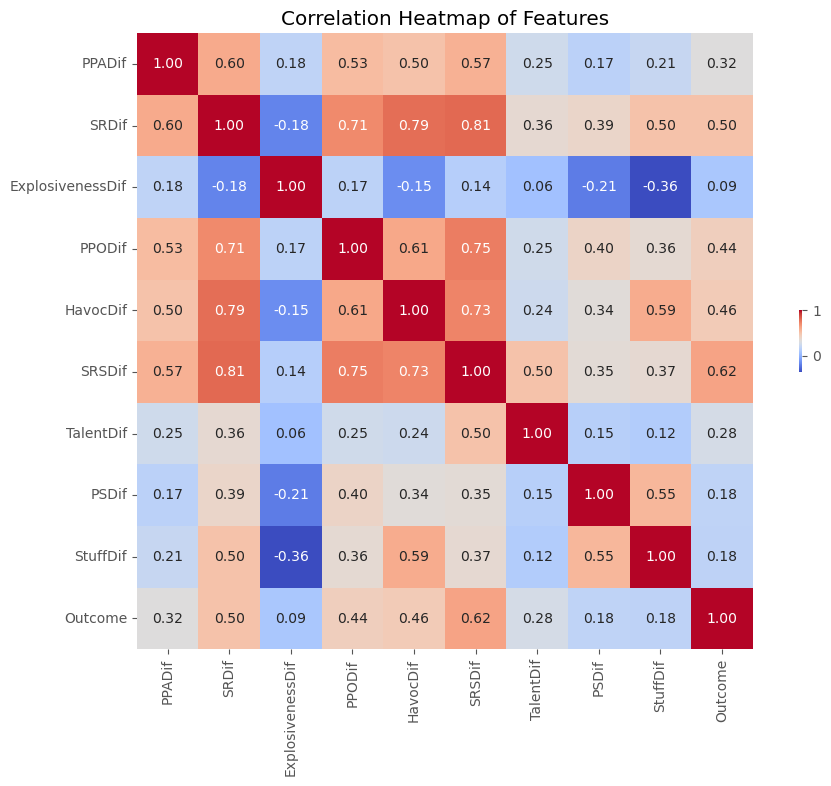

PPADif              0.323095
SRDif               0.500897
ExplosivenessDif    0.094519
PPODif              0.435180
HavocDif            0.458574
SRSDif              0.624688
TalentDif           0.277287
PSDif               0.181313
StuffDif            0.177239
Outcome             1.000000
Name: Outcome, dtype: float64


In [22]:
plt.figure(figsize=(12, 8))
correlation_matrix = CFB_train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .1})
plt.title('Correlation Heatmap of Features')
plt.show()

print(correlation_matrix['Outcome'])

C:\Users\Kyle Walton\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Kyle Walton\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Kyle Walton\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Kyle Walton\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


C:\Users\Kyle Walton\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Kyle Walton\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Kyle Walton\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Kyle Walton\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


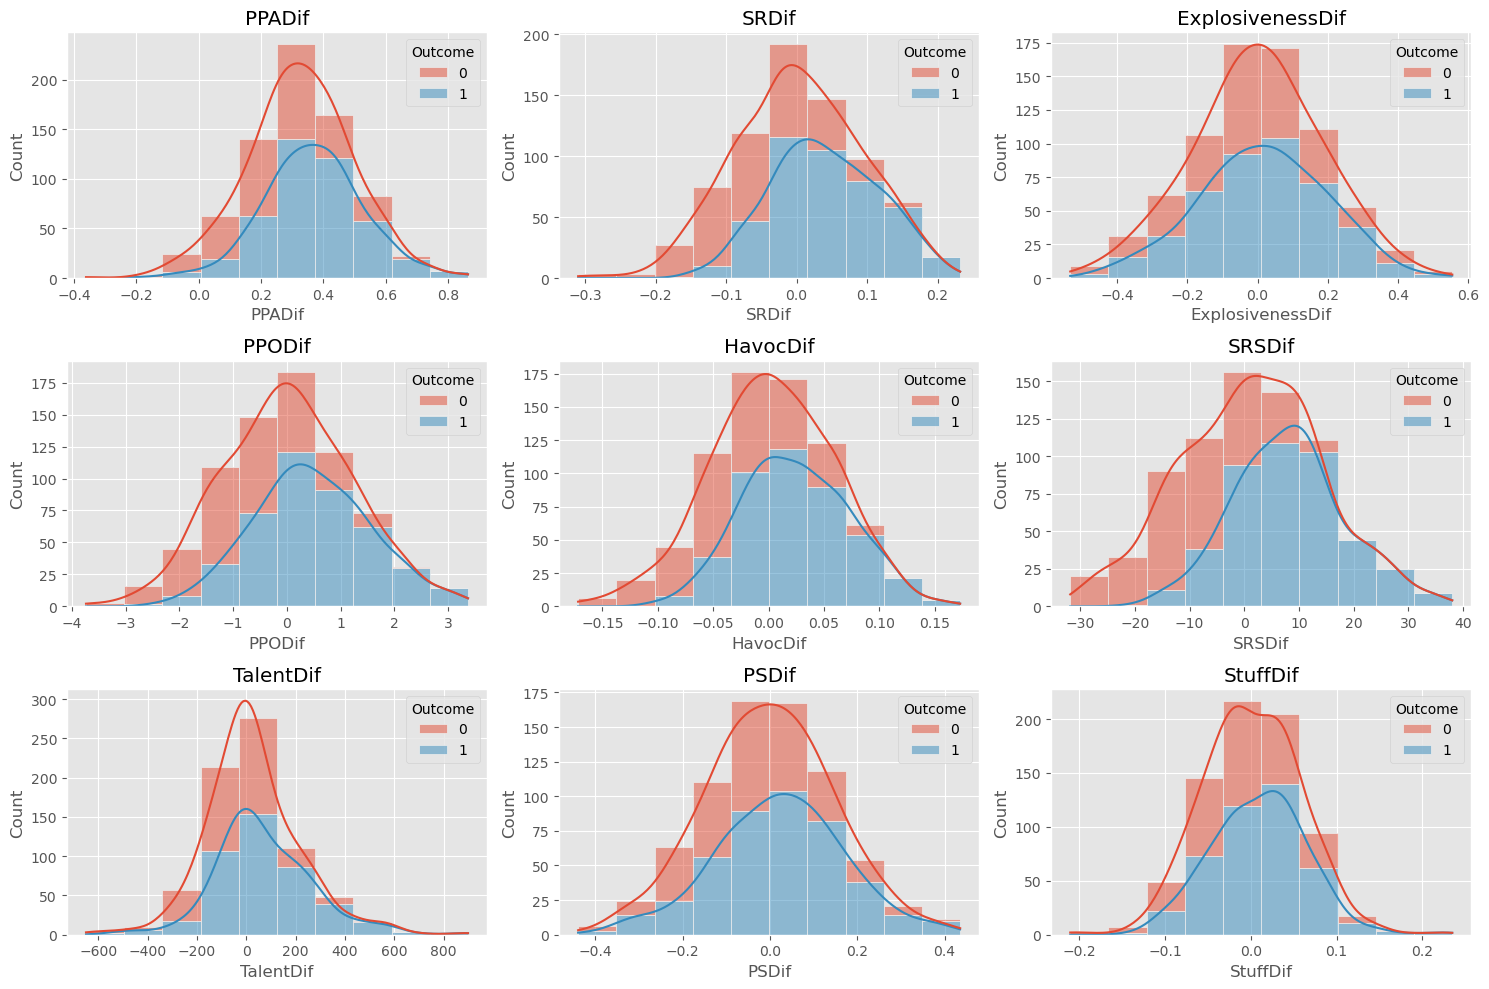

In [28]:
# Create histograms for each variable
features = ['PPADif', 'SRDif', 'ExplosivenessDif', 'PPODif', 
            'HavocDif', 'SRSDif', 'TalentDif', 'PSDif', 'StuffDif']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=CFB, x=feature, hue='Outcome', multiple='stack', bins=10, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

C:\Users\Kyle Walton\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Kyle Walton\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Kyle Walton\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Kyle Walton\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


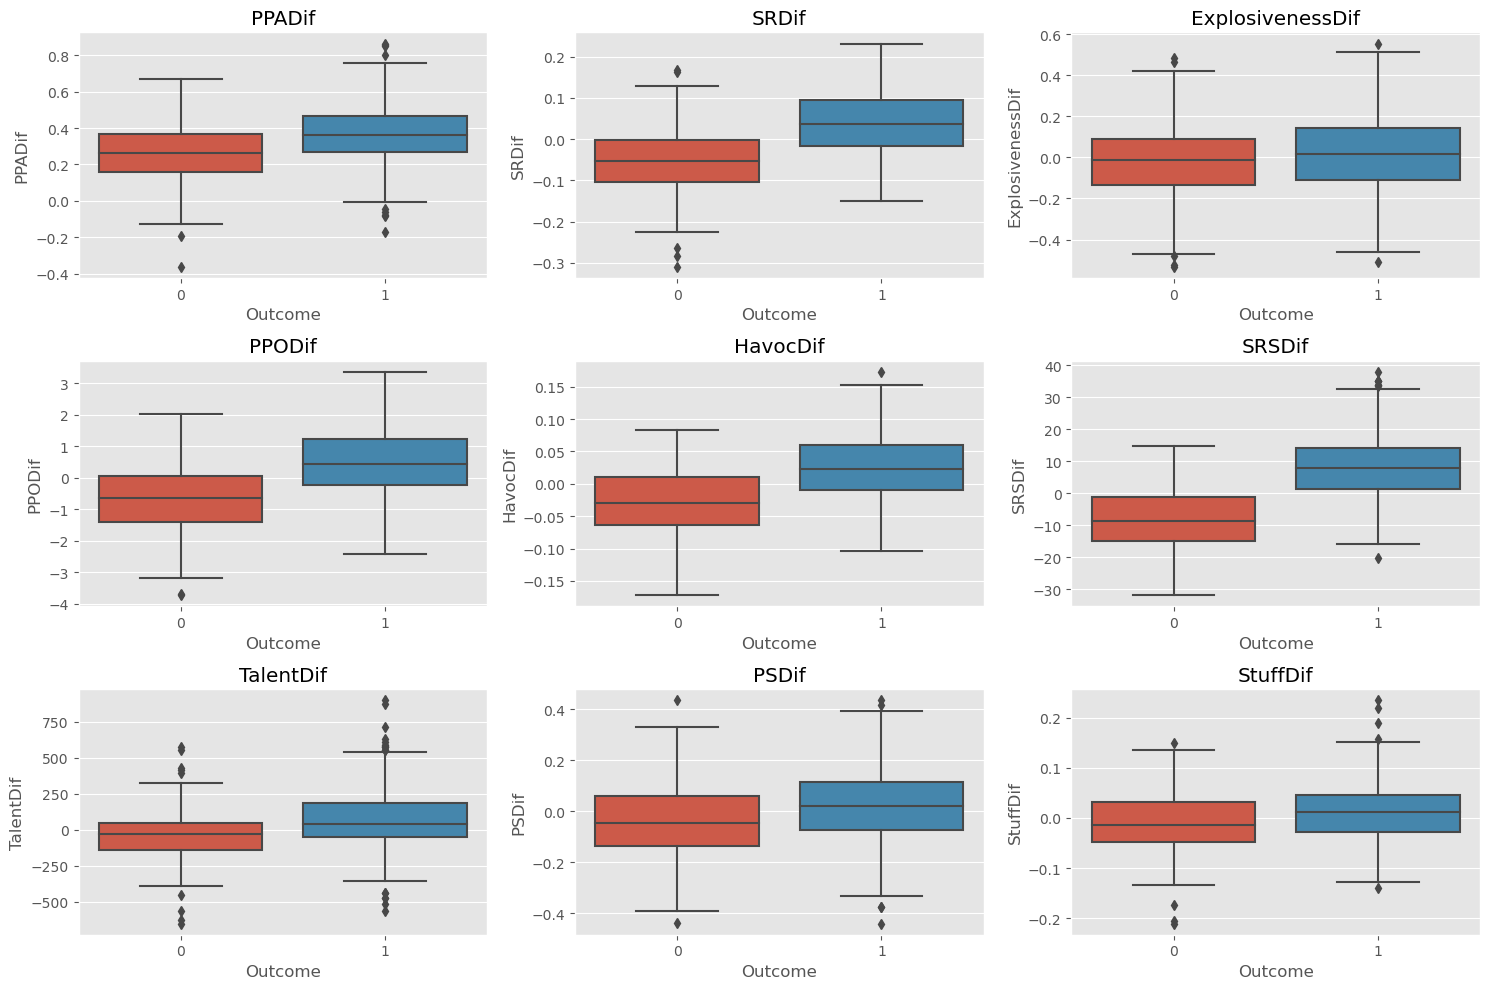

In [79]:
# Box Plots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='Outcome', y=feature, data=CFB)
    plt.title(feature)
plt.tight_layout()
plt.show()

### Preprocess Data

In [29]:
#scale data (needed for svm and stack models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Binary NN Model

# instantiate an object of the Sequential class
model = Sequential()

# add input and hidden layers
model.add(Dense(512, activation='relu', input_dim=9))
model.add(Dense(512, activation='relu'))

# add output layer with sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

# use binary_crossentropy loss and accuracy metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [383]:
model = Sequential([
    layers.Input(shape=(9,)),  # Input layer with 9 features
    layers.Dense(90, activation='swish'),
    layers.Dropout(0.3),
    layers.Dense(270, activation='swish'),
    layers.Dropout(0.9),
    layers.Dense(90, activation='swish'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit (binary output)
])

# Compile the model
model.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [384]:
#train the data
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=300)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.4911 - loss: 0.7027 - val_accuracy: 0.7651 - val_loss: 0.6500
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5883 - loss: 0.6616 - val_accuracy: 0.7785 - val_loss: 0.6233
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6376 - loss: 0.6446 - val_accuracy: 0.7852 - val_loss: 0.5974
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6611 - loss: 0.6259 - val_accuracy: 0.7785 - val_loss: 0.5741
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7203 - loss: 0.5902 - val_accuracy: 0.7718 - val_loss: 0.5508
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7170 - loss: 0.5800 - val_accuracy: 0.7785 - val_loss: 0.5293
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7238 - loss: 0.5498 - val_accuracy: 0.7718 - val_loss: 0.5104
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7349 - loss: 0.5439 - val_accuracy: 0.7718 - val_loss

Epoch 52/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7752 - loss: 0.4548 - val_accuracy: 0.8322 - val_loss: 0.4056
Epoch 53/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7585 - loss: 0.4697 - val_accuracy: 0.8322 - val_loss: 0.4052
Epoch 54/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7807 - loss: 0.4398 - val_accuracy: 0.8322 - val_loss: 0.4052
Epoch 55/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7853 - loss: 0.4384 - val_accuracy: 0.8322 - val_loss: 0.4051
Epoch 56/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7696 - loss: 0.4567 - val_accuracy: 0.8322 - val_loss: 0.4049
Epoch 57/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7751 - loss: 0.4645 - val_accuracy: 0.8322 - val_loss: 0.4048
Epoch 58/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7975 - loss: 0.4513 - val_accuracy: 0.8322 - val_loss: 0.4049
Epoch 59/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7729 - loss: 0.4409 - val_accuracy: 0.8389 - v

[]

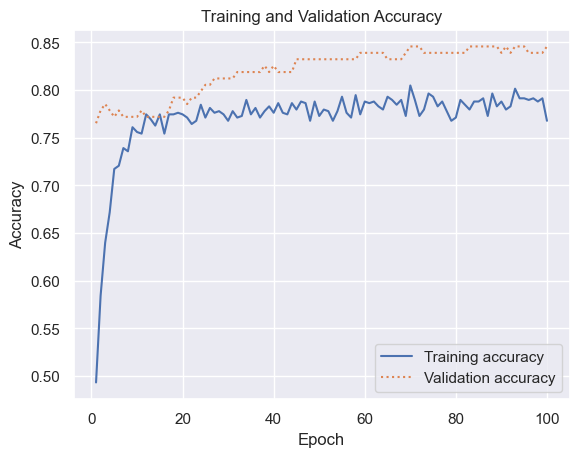

In [385]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [424]:
import statsmodels as sm
alpha = .5
conf_interval = model.conf_int(alpha)
print(conf_interval)

AttributeError: 'Sequential' object has no attribute 'conf_int'

### Predictions

In [ ]:
#function to turn boolean predictions into 'win' or 'loss'
predicted_classes = (predictions > 0.5).astype(int)

In [440]:
# Function to make predictions
def outcome_predict(list1, list2):  
    new_column_names = ['tr','oppa','osr','oexplosive','op','os',
                        'oppo','ohavoc','dppa','dsr','dexplosive',
                        'dp','ds','dppo','dhavoc','srs']

    for df in list2:
        if len(new_column_names) != len(df.columns):
            raise ValueError("Length of new_column_names must match the number of columns in each DataFrame in list2.")

    # Rename columns for DataFrames in list2
    renamed_list2 = [df.rename(columns=dict(zip(df.columns, new_column_names))) for df in list2]
    
    # Ensure both lists have the same number of DataFrames
    if len(list1) != len(renamed_list2):
        raise ValueError("Both lists must have the same number of DataFrames.")

    # Combine the DataFrames horizontally and ensure matching indices
    combined_list = []
    for df1, df2 in zip(list1, renamed_list2):
        if len(df1) != len(df2):
            raise ValueError("DataFrames must have the same number of rows to combine horizontally.")
        combined_list.append(pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1))
    
    # Concatenate all combined DataFrames into a single DataFrame
    final_combined_df = pd.concat(combined_list, ignore_index=True)
    
    
    #Feature engineering to reduce features from 20 to 5
    final_combined_df['PPA'] = final_combined_df['offense.ppa'] + final_combined_df['dppa']
    final_combined_df['SR'] = final_combined_df['offense.success_rate'] + final_combined_df['dsr']
    final_combined_df['Explosiveness'] = final_combined_df['offense.explosiveness'] + final_combined_df['dexplosive']
    final_combined_df['PPO'] = final_combined_df['offense.points_per_opportunity'] + final_combined_df['dppo']
    final_combined_df['Havoc'] = final_combined_df['defense.havoc.total'] + final_combined_df['ohavoc']
    final_combined_df['PS'] = final_combined_df['offense.power_success'] + final_combined_df['dp']
    final_combined_df['Stuff'] = final_combined_df['defense.stuff_rate'] + final_combined_df['os']
    
    
    final_combined_df['PPA1'] = final_combined_df['oppa'] + final_combined_df['defense.ppa']
    final_combined_df['SR1'] = final_combined_df['osr'] + final_combined_df['defense.success_rate']
    final_combined_df['Explosiveness1'] = final_combined_df['oexplosive'] + final_combined_df['defense.explosiveness']
    final_combined_df['PPO1'] = final_combined_df['oppo'] + final_combined_df['defense.points_per_opportunity']
    final_combined_df['Havoc1'] = final_combined_df['dhavoc'] + final_combined_df['offense.havoc.total']
    final_combined_df['PS1'] = final_combined_df['op'] + final_combined_df['defense.power_success']
    final_combined_df['Stuff1'] = final_combined_df['ds'] + final_combined_df['offense.stuff_rate'] 
    
    final_combined_df['PPADif'] = final_combined_df['PPA']-final_combined_df['PPA1']
    final_combined_df['SRDif'] = final_combined_df['SR']-final_combined_df['SR1']
    final_combined_df['ExplosivenessDif'] = final_combined_df['Explosiveness']-final_combined_df['Explosiveness1']
    final_combined_df['PPODif'] = final_combined_df['PPO']-final_combined_df['PPO1']
    final_combined_df['HavocDif'] = final_combined_df['Havoc']-final_combined_df['Havoc1']
    final_combined_df['SRSDif'] = final_combined_df['rating'] - final_combined_df['srs']
    final_combined_df['TalentDif'] = final_combined_df['talent'] - final_combined_df['tr']
    final_combined_df['PSDif'] = final_combined_df['PS'] - final_combined_df['PS1']
    final_combined_df['StuffDif'] = final_combined_df['Stuff'] - final_combined_df['Stuff1']
    
    final_combined_df = final_combined_df.drop(['offense.ppa','offense.success_rate','offense.explosiveness','offense.points_per_opportunity','offense.havoc.total',
                                               'defense.ppa','defense.success_rate','defense.explosiveness','defense.points_per_opportunity', 'defense.havoc.total',
                                               'oppa','osr','oexplosive','oppo','ohavoc','dppa','dsr','dexplosive','dppo','dhavoc',
                                               'PPA', 'SR', 'Explosiveness','PPO','Havoc','Stuff','Stuff1','PS','PS1','dp','ds','op','os',
                                                'offense.power_success', 'defense.power_success','offense.stuff_rate','defense.stuff_rate',
                                                'rating','tr','srs','talent',
                                               'PPA1', 'SR1', 'Explosiveness1','PPO1','Havoc1',],axis=1)
     #scale prediction
    predict_scaled = scaler.transform(final_combined_df)
    
    # Make predictions    
    predictions = model.predict(predict_scaled)
    predicted_classes = (predictions > 0.5).astype(int)
    result = ['Win' if pred == 1 else 'Loss' for pred in predicted_classes]
    
    numeric_cols = final_combined_df.select_dtypes(include='number').columns
    final_combined_df = final_combined_df.drop(columns=numeric_cols)
    # Add predictions to the combined DataFrame
    final_combined_df['Team'] = ['Georgia','Georgia','Georgia','Georgia','Georgia','Georgia','Georgia','Georgia','Georgia','Georgia','Georgia','Georgia','Georgia']
    final_combined_df['Opponent'] = ['OhioState','PennState','Tennessee','Southcarolina','OleMiss','BoiseState','Miami','TexasAM','Colorado','IowaState','Oregon','Indiana','Florida']

    final_combined_df['Predicted Result'] = result
    final_combined_df['% Chance to Win'] = predictions
    final_combined_df['% Chance to Win'] = round((final_combined_df['% Chance to Win'] * 100),2)
    
    
    return final_combined_df

In [451]:
teams = [Georgia,Georgia,Georgia,Georgia,Georgia,Georgia,Georgia,Georgia,Georgia,Georgia,Georgia,Georgia,Georgia]
opponents = [OhioState,PennState,Tennessee,SouthCarolina,OleMiss,BoiseState,Miami,TexasAM,Colorado,IowaState,Oregon,Indiana,Florida]


In [452]:
outcome_predict(teams, opponents)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


,Team,Opponent,Predicted Result,% Chance to Win
0,Georgia,OhioState,Win,58.880001
1,Georgia,PennState,Win,83.370003
2,Georgia,Tennessee,Win,80.839996
3,Georgia,Southcarolina,Win,83.290001
4,Georgia,OleMiss,Win,82.389999
5,Georgia,BoiseState,Win,82.500000
6,Georgia,Miami,Win,66.360001
7,Georgia,TexasAM,Win,77.639999
8,Georgia,Colorado,Win,86.930000
9,Georgia,IowaState,Win,88.830002
